# ATP13A2
[Kufor-Rakeb syndrome (KRS)](https://omim.org/entry/606693) and 
[autosomal recessive spastic paraplegia-78 (SPG78)](https://omim.org/entry/617225) are both
caused by homozygous or compound heterozygous mutation in the ATP13A2 gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


### ATP13A2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ATP13A2.

In [2]:
gene_symbol = 'ATP13A2'
mane_tx_id = 'NM_022089.4'
mane_protein_id = 'NP_071372.1' # polyamine-transporting ATPase 13A2 isoform 1"

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.22') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 44/44 [00:00<00:00, 645.97individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #3
    phenotype-features
      #11
       warnings:
       ·HP:6000029 is not in HPO version `2023-10-09`. Correct the HPO term or use the latest HPO for the analysis


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Bradykinesia,HP:0002067,33
Parkinsonism,HP:0001300,30
Babinski sign,HP:0003487,29
Dementia,HP:0000726,27
Rigidity,HP:0002063,26
Hyperreflexia,HP:0001347,26
Dysarthria,HP:0001260,22
Supranuclear gaze palsy,HP:0000605,19
Slow saccadic eye movements,HP:0000514,17
Mask-like facies,HP:0000298,14


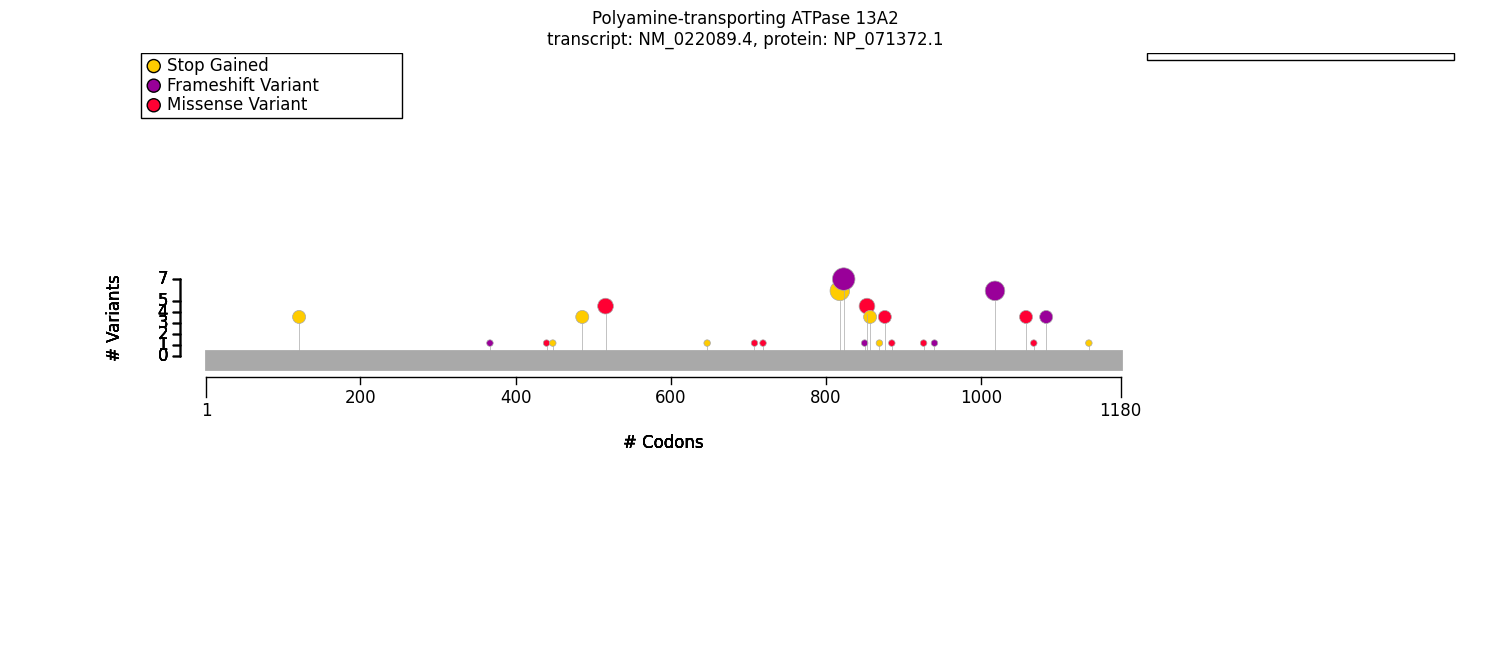

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

atp13a2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
atp13a2_fig.tight_layout()

## Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate
from gpsea.view import MtcStatsViewer

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = biallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense, 
    partitions=((0,1), (2,)), 
    a_label="missense", 
    b_label="other")

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)


viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,10
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,36
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,118


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Supranuclear gaze palsy [HP:0000605]                                               3/7   
Bradykinesia [HP:0002067]                                                        10/15   
Tremor [HP:0001337]                                                               3/10   
Slow saccadic eye movements [HP:0000514]                                           4/8   
Dementia [HP:0000726]                                                             9/13   
Babinski sign [HP:0003487]                                                       10/11   
Parkinsonism [HP:0001300]                                                        11/15   
Rigidity [HP:0002063]                                                             9/10   
Hypertonia [HP:0001276]                                                          11/11   
Abnormality of extrapyramidal motor function [H...                               11/11   
Abnormal conjugate eye movement [HP:0000549]                                       3/3   
Mental deterioration [HP:0001268]                                                  9/9   
Cognitive impairment [HP:0100543]                                                11/11   
Hyperreflexia [HP:0001347]                                                         8/8   
Abnormal reflex [HP:0031826]                                                     11/11   
Abnormal superficial reflex [HP:0031828]                                         10/10   
Abnormal pyramidal sign [HP:0007256]                                             10/10   
Upper motor neuron dysfunction [HP:0002493]                                      10/10   
Visual hallucination [HP:0002367]                                                  1/3   
Dystonia [HP:0001332]                                                              5/9   
Dysarthria [HP:0001260]                                                            9/9   
Abnormality of speech or vocalization [HP:0002167]                               10/10   
Abnormal communication [HP:0034434]                                              10/10   
Abnormal brain morphology [HP:0012443]                                             7/7   
Morphological central nervous system abnormalit...                                 7/7   

Allele group                                               other/other  \
                                                   Percent       Count   
Supranuclear gaze palsy [HP:0000605]                   43%       16/19   
Bradykinesia [HP:0002067]                              67%       23/26   
Tremor [HP:0001337]                                    30%       11/21   
Slow saccadic eye movements [HP:0000514]               50%       13/18   
Dementia [HP:0000726]                                  69%       18/22   
Babinski sign [HP:0003487]                             91%       19/24   
Parkinsonism [HP:0001300]                              73%       19/23   
Rigidity [HP:0002063]                                  90%       18/21   
Hypertonia [HP:0001276]                               100%       23/23   
Abnormality of extrapyramidal motor function [H...    100%       23/23   
Abnormal conjugate eye movement [HP:0000549]          100%       16/16   
Mental deterioration [HP:0001268]                     100%       18/18   
Cognitive impairment [HP:0100543]                     100%       18/18   
Hyperreflexia [HP:0001347]                            100%       21/22   
Abnormal reflex [HP:0031826]                          100%       24/24   
Abnormal superficial reflex [HP:0031828]              100%       19/19   
Abnormal pyramidal sign [HP:0007256]                  100%       19/19   
Upper motor neuron dysfunction [HP:0002493]           100%       20/20   
Visual hallucination [HP:0002367]                      33%        9/22   
Dystonia [HP:00

In [10]:
from gpsea.analysis.predicate.genotype import diagnosis_predicate

krs_id = "OMIM:606693" # Kufor-Rakeb syndrome
sp78_id = "OMIM:617225" # Spastic paraplegia 78, autosomal recessive

disease_predicate = diagnosis_predicate(
    diagnoses=(krs_id, sp78_id),
    labels=('Kufor-Rakeb syndrome', 'Spastic paraplegia 78, autosomal recessive'),
)

dx_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=disease_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=dx_result)

Diagnosis                                          OMIM:606693          \
                                                         Count Percent   
Parkinsonism [HP:0001300]                                27/27    100%   
Bradykinesia [HP:0002067]                                29/31     94%   
Slow saccadic eye movements [HP:0000514]                 15/18     83%   
Dementia [HP:0000726]                                    23/26     88%   
Supranuclear gaze palsy [HP:0000605]                     17/20     85%   
Dystonia [HP:0001332]                                    11/18     61%   
Tremor [HP:0001337]                                      13/25     52%   
Dysarthria [HP:0001260]                                  13/13    100%   
Babinski sign [HP:0003487]                               19/24     79%   
Rigidity [HP:0002063]                                    26/30     87%   
Hypertonia [HP:0001276]                                  27/27    100%   
Abnormality of extrapyramidal motor function [H...       30/30    100%   
Abnormal conjugate eye movement [HP:0000549]             17/17    100%   
Mental deterioration [HP:0001268]                        23/23    100%   
Cognitive impairment [HP:0100543]                        23/23    100%   
Hyperreflexia [HP:0001347]                               23/24     96%   
Abnormal reflex [HP:0031826]                             25/25    100%   
Abnormal superficial reflex [HP:0031828]                 19/19    100%   
Abnormal pyramidal sign [HP:0007256]                     19/19    100%   
Upper motor neuron dysfunction [HP:0002493]              19/19    100%   
Abnormality of speech or vocalization [HP:0002167]       14/14    100%   
Abnormal communication [HP:0034434]                      14/14    100%   
Abnormal brain morphology [HP:0012443]                   12/12    100%   
Morphological central nervous system abnormalit...       12/12    100%   

Diagnosis                                          OMIM:617225          \
                                                         Count Percent   
Parkinsonism [HP:0001300]                                 3/11     27%   
Bradykinesia [HP:0002067]                                 4/10     40%   
Slow saccadic eye movements [HP:0000514]                   2/8     25%   
Dementia [HP:0000726]                                      4/9     44%   
Supranuclear gaze palsy [HP:0000605]                       2/6     33%   
Dystonia [HP:0001332]                                      1/6     17%   
Tremor [HP:0001337]                                        1/6     17%   
Dysarthria [HP:0001260]                                   9/10     90%   
Babinski sign [HP:0003487]                               10/11     91%   
Rigidity [HP:0002063]                                      1/1    100%   
Hypertonia [HP:0001276]                                    7/7    100%   
Abnormality of extrapyramidal motor function [H...         4/4    100%   
Abnormal conjugate eye movement [HP:0000549]               2/2    100%   
Mental deterioration [HP:0001268]                          4/4    100%   
Cognitive impairment [HP:0100543]                          6/6    100%   
Hyperreflexia [HP:0001347]                                 6/6    100%   
Abnormal reflex [HP:0031826]                             10/10    100%   
Abnormal superficial reflex [HP:0031828]                 10/10    100%   
Abnormal pyramidal sign [HP:0007256]                     10/10    100%   
Upper motor neuron dysfunction [HP:0002493]              11/11    100%   
Abnormality of speech or vocalization [HP:0002167]         9/9    100%   
Abnormal communication [HP:0034434]                        9/9    100%   
Abnormal brain morphology [HP:0012443]                   10/10    100%   
Morphological central nervous system abnormalit...       10/10    100%   

Diagnosis                                                              \
                                                   Corrected p values   
Park

# Summary

In [11]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=dx_result,
    ),
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [13]:
summarizer.process_latex(report=report, protein_fig=atp13a2_fig)

Figure saved to ../../supplement/img/ATP13A2_protein_diagram-draft.pdf
Output to ../../supplement/tex/ATP13A2_summary_draft.tex
